In [1]:
%pip install altair pandas plotly pygal cairosvg ruamel.yaml PrefixedUnit

ERROR: Could not find a version that satisfies the requirement PrefixedUnit (from versions: none)
ERROR: No matching distribution found for PrefixedUnit
Note: you may need to restart the kernel to use updated packages.


In [2]:
"""
    METRICS names come from PAPI
"""
import pandas as pd
import altair as alt
import numpy as np
import plotly.express as px

data = pd.read_csv("example_omp18_papi.csv")
data1 = pd.read_csv("example_omp1_papi.csv")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 30)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

class ComplexRadar():
    def _invert(self, x, limits):
        return limits[1] - (x - limits[0])

    def _scale_data(self, data, ranges):
        """scales data[1:] to ranges[0],
        inverts if the scale is reversed"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        if x1 > x2:
            d = self._invert(d, (x1, x2))
            x1, x2 = x2, x1
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            if y1 > y2:
                d = self._invert(d, (y1, y2))
                y1, y2 = y2, y1
            sdata.append((d-y1) / (y2-y1) 
                         * (x2 - x1) + x1)
        return sdata
    def create_ranges(self):
        # we need to change this formula here somehow
        x = [(self.data[x].min() - (self.data[x].max() - self.data[x].min()) / 5, self.data[x].max() + (self.data[x].max() - self.data[x].min()) / 5) for x in self.labels] 
        return x
        
    def __init__(self, fig, labels, data, functions_to_plot,
                 n_ordinate_levels=6):
        # calculate the ranges and the labels
        self.functions_to_plot = functions_to_plot
        
        self.labels = labels
        self.data = data
        self.ranges = self.create_ranges()
        ranges = self.ranges
        
        angles = np.arange(0, 360, 360./len(labels))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(labels))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=labels, fontweight='bold', fontsize=15)
        axes[0].tick_params(pad=40)
        
        
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            
        for i, ax in enumerate(axes):
            grid = np.linspace(*self.ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if self.ranges[i][0] > self.ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ax = axes[0]

    def _plot(self, data, label):
        sdata = self._scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], label=label)

    def plot(self):
        lines = []
        for label in self.functions_to_plot:
            vars_plt = self.data.loc[self.data['Function'] == label][self.labels].values.tolist()[0]
            # not sure here why the output is not flat
            self._plot(vars_plt, label)
            lines.append(vars_plt)
        self.ax.legend()
        return self.ax
    def fill(self, data, *args, **kw):
        sdata = self._scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)



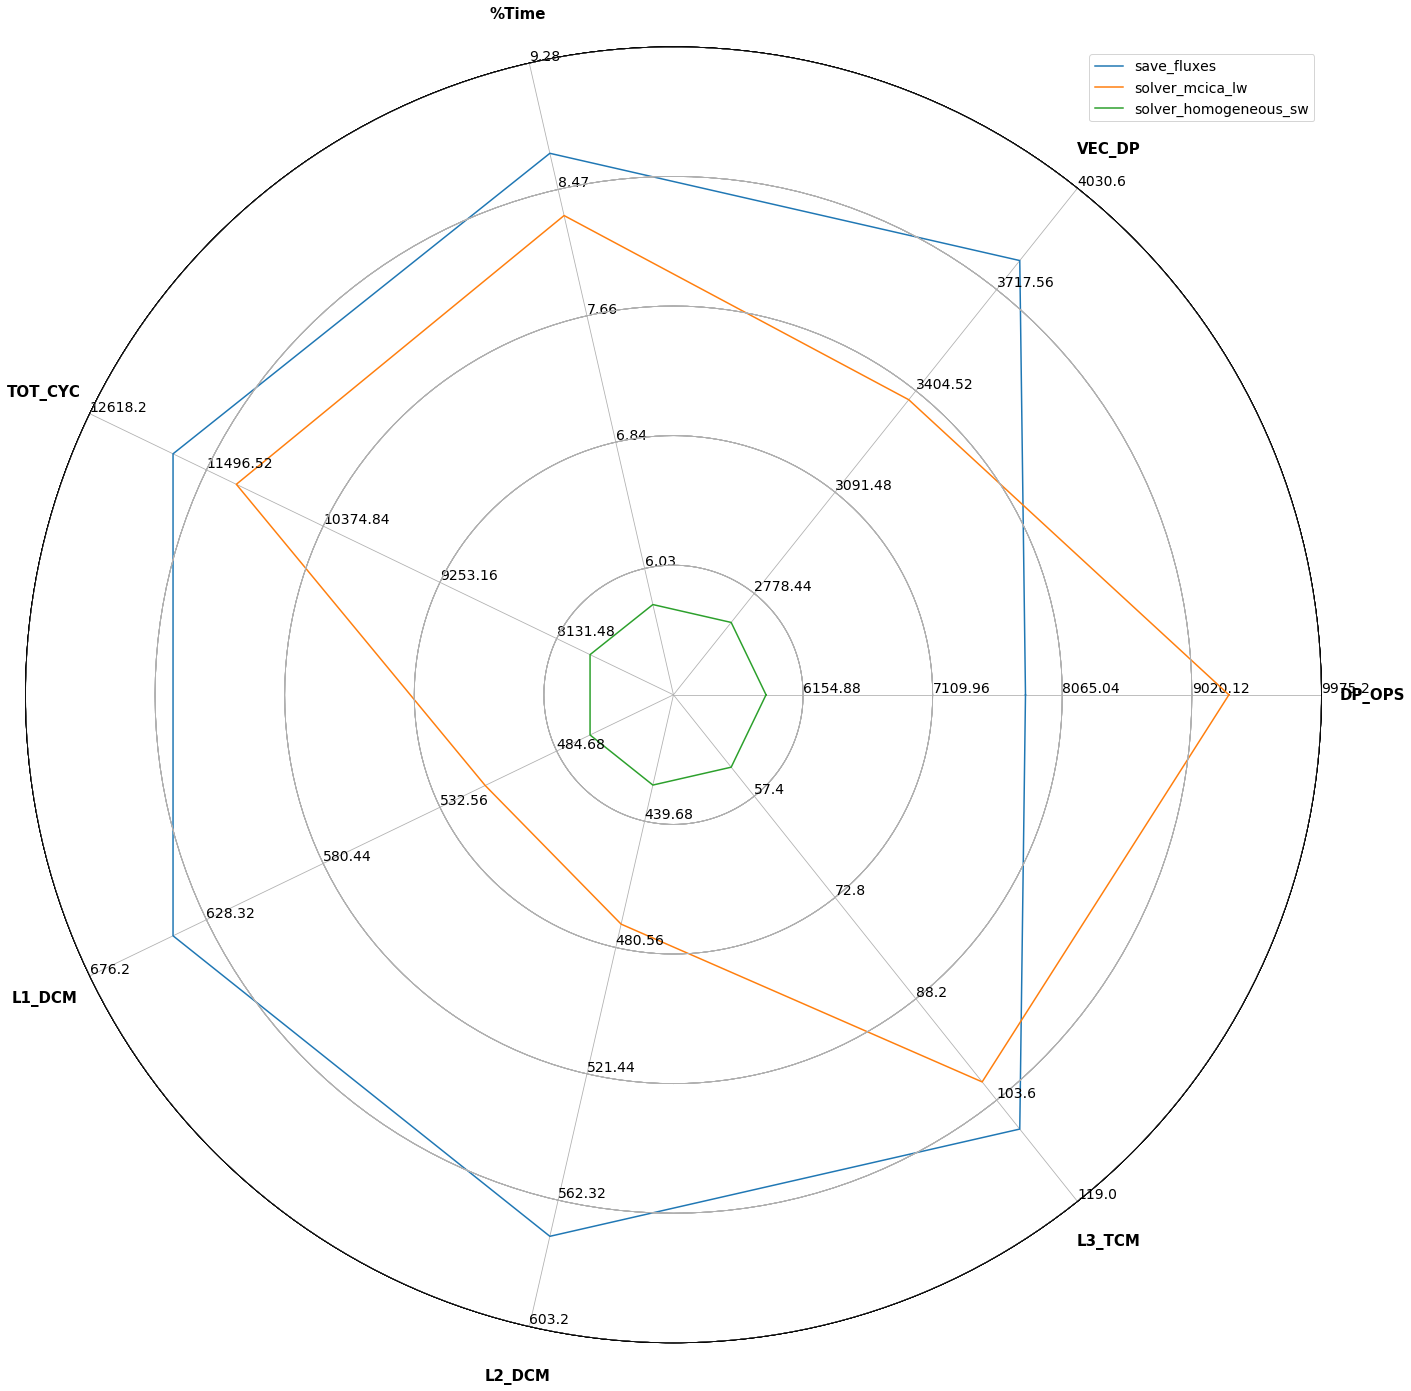

In [4]:
functions_to_plot = ['save_fluxes', 'solver_mcica_lw', 'solver_homogeneous_sw']
data2 = data.loc[data['Function'].isin(functions_to_plot)]

labels = ['DP_OPS', 'VEC_DP', '%Time', 'TOT_CYC', 'L1_DCM', 'L2_DCM', 'L3_TCM']

fig1 = plt.figure(figsize=(20, 20))
radar = ComplexRadar(fig1, labels, data2, functions_to_plot)
radar.plot();

In [61]:
import plotly.graph_objects as go
import pandas as pd


df = pd.read_csv("example_omp1_papi.csv")
# plot the function from the example_omp18_papi.csv
functions_to_plot = df.head(100).tail(2)["Function"].to_list() + ['delta_eddington_scat_od', 'cloud_optics']
import json
import pprint
import pandas as pd

parsed_dict = {}
pp = pprint.PrettyPrinter(indent=3)

with open("callgraph.json") as f:
    data = json.load(f)
    # filter the data for easy handeling

    # data = { x : data[x] for x in keys_keep}

    for i in data.keys():
        for j in data[i]:
            name, scope, n_file = j.split(" ")
            if j not in parsed_dict:
                parsed_dict[name] = {}
                parsed_dict[name]['scope'] = scope.replace("[","").replace("]","")
                parsed_dict[name]['file'] = n_file.replace("(","").replace(")","")
                # name scope and file
            if name == i:
                parsed_dict[name]['parent'] = None
            else:
                parsed_dict[name]['parent'] = i


df_parents = pd.DataFrame.from_dict(parsed_dict).transpose()
df = df.loc[df["Function"].isin(functions_to_plot)]
df_parents = df_parents.loc[df_parents.index.isin(functions_to_plot) & df_parents.parent.isin(functions_to_plot)]
df = df.set_index('Function').join(df_parents).fillna('').reset_index()

primary_feature = 'WallTime'
features = ['Function',"WallTime", 'parent']

df = df[features]
df = df.to_dict()
df_new = {}
for i in df.keys():
    if i == "Function":
        df_new['function_name'] = list(df[i].values())
    elif i == "WallTime":
        df_new['value'] = list(df[i].values())
    else:
        df_new['parent'] = list(df[i].values())
fig =px.sunburst(
    df_new,
    names='function_name',
    parents='parent',
    values='value',
)

fig.update_layout(width=1000,
    height=1000,uniformtext=dict(minsize=6, mode='show'))
# fig.show()
print(fig.data)
print(fig.layout)


(Sunburst({
    'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
    'hovertemplate': 'function_name=%{label}<br>value=%{value}<br>parent=%{parent}<extra></extra>',
    'labels': array(['cloud_optics', 'delta_eddington_scat_od', 'rrtm_kgb11',
                     'allocate_aerosol_arrays_direct'], dtype=object),
    'name': '',
    'parents': array(['delta_eddington_scat_od', '', '', ''], dtype=object),
    'values': array([0.2  , 0.1  , 0.048, 0.034])
}),)
Layout({
    'height': 1000,
    'legend': {'tracegroupgap': 0},
    'margin': {'t': 60},
    'template': '...',
    'uniformtext': {'minsize': 6, 'mode': 'show'},
    'width': 1000
})


In [62]:
# Export the drawn figures to html objects that are going to be used in the React app
import plotly
plotly.io.orca.config.executable = '/usr/local/bin/orca'
fig.write_image("./sunburst.svg")
fig.write_image("./sunburst.svg")
fig.write_json('./sunburst.json')